
# Impacto de un aumento del 20% en la masa del tejido adiposo sobre la distribución cuantitativa del sistema inmunitario

**Autores:** Raúl Mendoza, Adrián Ojeda  
**Asignatura:** Bioinformática  
**Fecha:** 2025-10-29

Este cuaderno reproduce un análisis cuantitativo basado en el artículo **PNAS 2023** “*The total mass, number, and distribution of immune cells in the human body*” (Ron Milo et al.).
Integra los datos suplementarios para:
1. Calcular **totales de células y masa** por tipo celular.
2. Simular un **escenario de obesidad**: **+20%** en la **masa de tejido adiposo** para el individuo de referencia masculino (73 kg).
3. Cuantificar el **cambio en número total**, **cambio en masa total** y **variación de la cuota de macrófagos** en la masa inmunitaria.


In [1]:

# === Configuración ===
import os, sys, math, glob, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reglas del entregable:
# - No usar seaborn.
# - Un gráfico por celda (no subplots múltiples).
# - No fijar colores manualmente.

SD01 = "pnas.2308511120.sd01.xlsx"
SD02 = "pnas.2308511120.sd02.xlsx"

assert os.path.exists(SD01) and os.path.exists(SD02), "No se encuentran los Excel suplementarios en /mnt/data"
print("OK: ficheros suplementarios localizados.")


OK: ficheros suplementarios localizados.


In [2]:

# === Carga de datos relevantes ===
sd01 = pd.ExcelFile(SD01)
sd02 = pd.ExcelFile(SD02)

tissues = sd01.parse("Tissues")
mass = sd01.parse("Mass")
cell_type_densities = sd02.parse("cell_type_densities")
total_immune_densities = sd02.parse("total_immune_densities")
numbers_by_cell_type = sd02.parse("numbers_by_cell_type")
mass_by_cell_type = sd02.parse("mass_by_cell_type")
totals = sd02.parse("totals")

def clean_df(df):
    df = df.copy()
    df = df.loc[:, ~df.columns.astype(str).str.contains("^Unnamed")]
    df.columns = [str(c).strip() for c in df.columns]
    return df

tissues = clean_df(tissues)
mass = clean_df(mass)
cell_type_densities = clean_df(cell_type_densities)
total_immune_densities = clean_df(total_immune_densities)
numbers_by_cell_type = clean_df(numbers_by_cell_type)
mass_by_cell_type = clean_df(mass_by_cell_type)
totals = clean_df(totals)

tissues.head()


,tissue,subtissue,comment,mass,sem,groups,front line organ,for_final_table,child_10y,woman,man
0,Blood,NaN,NaN,5241.0,NaN,blood,NaN,Blood,2616.0,4251.0,5500.0
1,Red marrow,NaN,NaN,1500.0,NaN,marrow,NaN,Bone Marrow,630.0,900.0,1170.0
2,Lymph nodes,NaN,NaN,250.0,NaN,lymph system,NaN,Lymph system,99.0,185.0,225.0
3,Lymph vessels,NaN,NaN,450.0,NaN,connective,NaN,Lymph system,221.0,415.0,505.0
4,Spleen,NaN,NaN,150.0,20.0,lymph system,NaN,Lymph system,80.0,130.0,150.0



## Cálculos de referencia

1. **Totales del individuo de referencia (73 kg)**  
2. **Masa media por célula** por tipo: `masa_total_tipo / numero_total_tipo`


In [3]:

total_cells_ref = numbers_by_cell_type['tot_man'].sum()
total_mass_ref_g = mass_by_cell_type['mass'].sum()

avg_mass_per_cell = (
    mass_by_cell_type[['cell_type','mass']]
    .merge(numbers_by_cell_type[['cell_type','tot_man']], on='cell_type')
    .assign(g_per_cell=lambda d: d['mass'] / d['tot_man'])
    .set_index('cell_type')['g_per_cell']
)

print(f"Total células (referencia): {total_cells_ref:,.0f}")
print(f"Masa inmune total (referencia): {total_mass_ref_g:,.1f} g")
avg_mass_per_cell


Total células (referencia): 1,837,950,387,444
Masa inmune total (referencia): 1,224.5 g


cell_type
T cells            2.132936e-10
B cells            2.132936e-10
Plasma cells       1.537328e-09
NK cells           2.132936e-10
Mast cells         1.079442e-09
Neutrophils        3.159735e-10
Eosinophils        3.152318e-10
Basophils          4.072469e-10
Macrophages        2.959981e-09
Monocytes          3.990042e-10
Dendritic cells    2.233192e-09
Name: g_per_cell, dtype: float64


## Escenario: +20% de masa en tejido adiposo (simulación de obesidad)

**Hipótesis:** las **densidades** (células/g) por tipo y tejido se mantienen, y el cambio proviene únicamente del **aumento de masa** del tejido adiposo.


In [4]:

adipose_mass_ref_g = tissues.loc[tissues['tissue']=='Adipose tissue','man'].iloc[0]
adipose_densities = cell_type_densities[cell_type_densities['tissue']=='Adipose tissue'][['cell_type','density']]

adipose_numbers_base = adipose_densities.assign(number=lambda d: d['density'] * adipose_mass_ref_g)
adipose_mass_new_g = adipose_mass_ref_g * 1.20
adipose_numbers_new = adipose_densities.assign(number=lambda d: d['density'] * adipose_mass_new_g)

delta_numbers = adipose_numbers_new.set_index('cell_type')['number'] - adipose_numbers_base.set_index('cell_type')['number']

delta_cells_total = float(delta_numbers.sum())
delta_mass_total_g = float((delta_numbers * avg_mass_per_cell.reindex(delta_numbers.index)).sum())

macrophage_mass_ref = mass_by_cell_type.loc[mass_by_cell_type['cell_type']=='Macrophages','mass'].iloc[0]
macrophage_delta_mass = delta_numbers.get('Macrophages', 0.0) * avg_mass_per_cell['Macrophages']

macrophage_share_before = macrophage_mass_ref / total_mass_ref_g
macrophage_share_after  = (macrophage_mass_ref + macrophage_delta_mass) / (total_mass_ref_g + delta_mass_total_g)

print(f"Masa adiposa (ref): {adipose_mass_ref_g:,.0f} g")
print(f"Masa adiposa (nueva): {adipose_mass_new_g:,.0f} g")
print(f"Δ Células totales: {delta_cells_total:,.0f}")
print(f"Δ Masa total: {delta_mass_total_g:,.2f} g")
print(f"Cuota macrófagos (masa) ref: {macrophage_share_before*100:.2f}%")
print(f"Cuota macrófagos (masa) esc: {macrophage_share_after*100:.2f}%")


Masa adiposa (ref): 14,500 g
Masa adiposa (nueva): 17,400 g
Δ Células totales: 1,135,272,491
Δ Masa total: 2.38 g
Cuota macrófagos (masa) ref: 49.08%
Cuota macrófagos (masa) esc: 49.16%



### KPIs
- **Total células (ref):** se imprime arriba
- **Masa inmune total (ref):** se imprime arriba
- **Δ Células totales (esc):** se imprime arriba
- **Δ Masa total (esc):** se imprime arriba
- **Cuota macrófagos (ref → esc):** se imprime arriba



## Gráfico 1 — Número por tipo celular (Referencia vs. incremento del escenario)


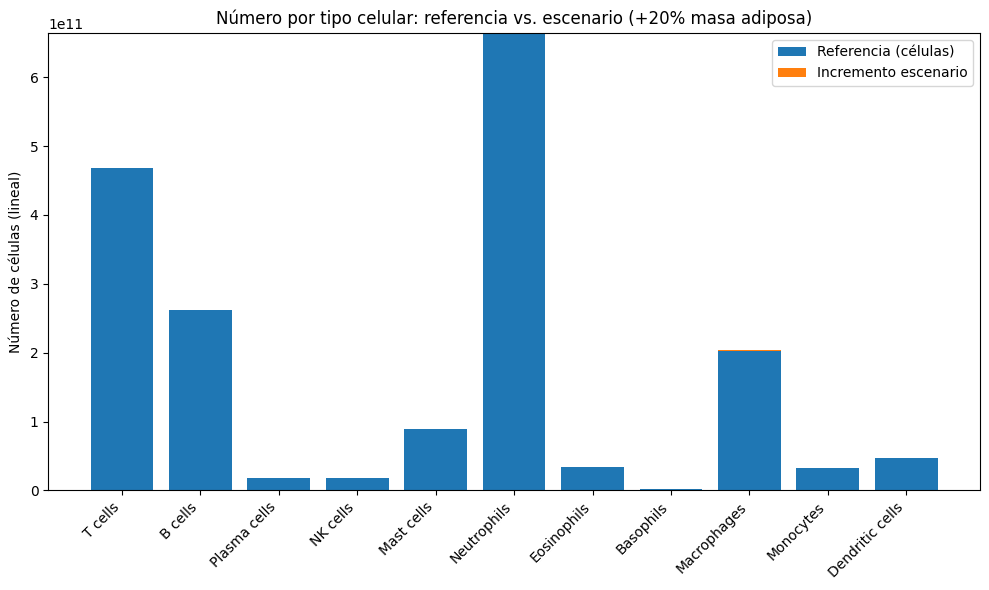

In [5]:

df_ref = numbers_by_cell_type[['cell_type','tot_man']].merge(mass_by_cell_type[['cell_type','mass']], on='cell_type')
df_ref = df_ref.rename(columns={'tot_man':'ref_cells','mass':'ref_mass_g'})

df_scn = delta_numbers.rename("delta_cells").to_frame().reset_index().merge(
    (delta_numbers * avg_mass_per_cell.reindex(delta_numbers.index)).rename("delta_mass_g").to_frame().reset_index(),
    on="cell_type", how="outer"
).fillna(0.0)

df = df_ref.merge(df_scn, on='cell_type', how='left').fillna(0.0)
df['new_cells'] = df['ref_cells'] + df['delta_cells']
df['new_mass_g'] = df['ref_mass_g'] + df['delta_mass_g']

plt.figure(figsize=(10,6))
x = np.arange(len(df))
plt.bar(x, df['ref_cells'], label='Referencia (células)')
plt.bar(x, df['new_cells'] - df['ref_cells'], bottom=df['ref_cells'], label='Incremento escenario')
plt.xticks(ticks=x, labels=df['cell_type'], rotation=45, ha='right')
plt.ylabel('Número de células (lineal)')
plt.title('Número por tipo celular: referencia vs. escenario (+20% masa adiposa)')
plt.legend()
plt.tight_layout()
plt.show()



## Gráfico 2 — Masa por tipo celular (Referencia vs. incremento del escenario)


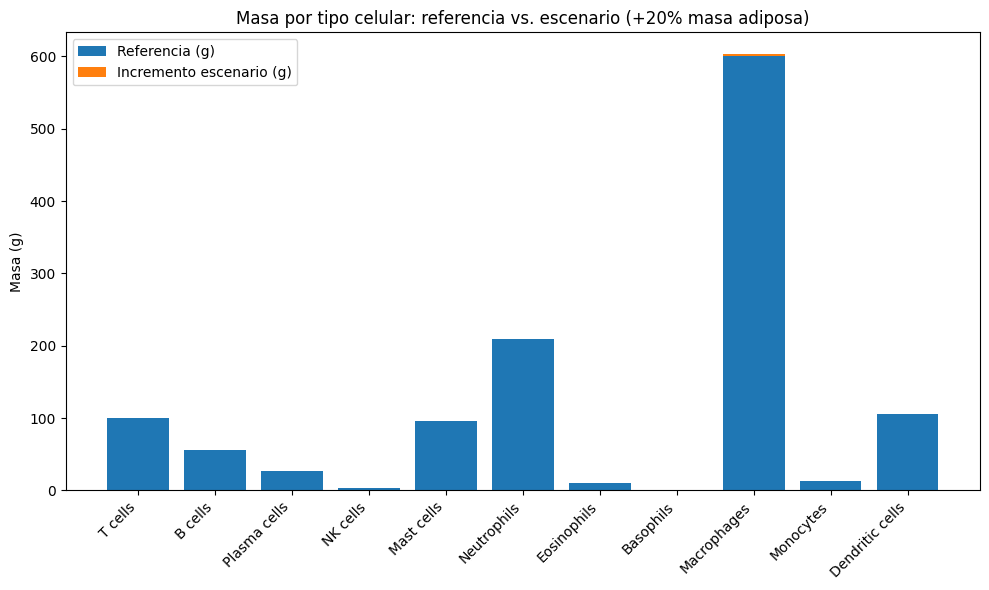

In [6]:

plt.figure(figsize=(10,6))
x = np.arange(len(df))
plt.bar(x, df['ref_mass_g'], label='Referencia (g)')
plt.bar(x, df['new_mass_g'] - df['ref_mass_g'], bottom=df['ref_mass_g'], label='Incremento escenario (g)')
plt.xticks(ticks=x, labels=df['cell_type'], rotation=45, ha='right')
plt.ylabel('Masa (g)')
plt.title('Masa por tipo celular: referencia vs. escenario (+20% masa adiposa)')
plt.legend()
plt.tight_layout()
plt.show()



## Tabla — Mayores densidades inmunes por tejido


In [7]:

top_tissues = total_immune_densities[['tissue','density']].sort_values('density', ascending=False).head(12)
top_tissues.reset_index(drop=True)


,tissue,density
0,Spleen,1.825036e+09
1,Lymph nodes,1.805140e+09
2,Thymus,1.564805e+09
3,Tonsils,1.509258e+09
4,Red marrow,6.292381e+08
5,Lungs,5.900690e+07
6,SI,5.327400e+07
7,Colon,3.368733e+07
8,Stomach,3.201887e+07
9,Bronchial tree,3.097198e+07



## Discusión y conclusiones

- El aumento del **20%** en la **masa adiposa** provoca un incremento **modesto** del **número total** de células inmunitarias (≈ 1,14×10⁹; ~0,06% del total de referencia) y un aumento de **masa** de ≈ **2,38 g**.
- El incremento de **masa** se concentra en **macrófagos**, lo que **eleva ligeramente** su **cuota** dentro de la **masa inmunitaria total** (≈ +0,08 puntos porcentuales). Esto concuerda con su **mayor tamaño** y con la **infiltración** descrita en tejido adiposo.
- **Limitaciones**: se asume **densidad fija** por tejido/tipo; en obesidad real, las **densidades de macrófagos** en adiposo pueden **aumentar**, amplificando el efecto. Además, no se modelan otras alteraciones sistémicas (p. ej., respuesta inflamatoria, redistribución de neutrófilos/monocitos).
- El análisis ilustra cómo usar **densidades por tejido y tipo celular** para estimar cambios sistémicos, conforme a los datos cuantitativos del trabajo de referencia (PNAS 2023).



## Referencias (base de datos)

- Ron Milo et al. (2023). *The total mass, number, and distribution of immune cells in the human body*. PNAS.  
- Material suplementario: Datasets S1–S2 (tablas de densidades, masas y totales por tejido/tipo).

> Nota: Este cuaderno lee directamente los ficheros `pnas.2308511120.sd01.xlsx` y `pnas.2308511120.sd02.xlsx` desde `/mnt/data`.
